# Data Assimilation using 4Dvar (Tangent Linear Models, Adjoints, and some good stuff in between)


**disclaimer:** a lot of this work has been collected from multiple resources which are cited at the end of this document. This is meant to be a practical teaching tool which provides a first look into coding a simple 4dvar scheme, please refer to the documents cited below for a more in depth treatment of this topic written by much smarter people than I. RUN WITH PYTHON 2! 

According to the ECMWF "data assimilation, specifically in weather foreasting is used to estimate initial conditions for the forecast model from meteorological observations... The purpose of data assimilation is to determine a best possible atmospheric state using observations and short range forecasts. Data assimilation is typically a sequential time stepping procedure, in which a previous model forecast is compared with newly recieved observations, the model state is then updated to reflect the observations, a new forecast is then initiated, and so on. The update step in the process is usually referred to as the **analysis**; the short model forecast used to produce the analysis is called the **background**". 

Here we will be using the Logistic Growth equation and the Lorenz 63 model, with simple time stepping schemes to show the technique of 4DVAR to assimilate data into the model, update the initial conditions, and run the model again. While the equations are simple, this tutorial is intended to give a practical background into data assimilation using tangent linear models and adjoint models. 


4Dvar, stands for four dimensional (space and time) variational approach. A variational approach finds the analysis that minimizes a cost function measuring its distance to the background and to the observations. 

We begin with Logistic growth equation. 

### Background information on Logistic Growth:
If you are unfamiliar with the logistic growth relationship, and what the equation accomplishes the following link gives the motivation.
[Logistic Growth](http://mathworld.wolfram.com/LogisticEquation.html). For our purposes it suffices to say that the first equation that we will be dealing with takes the following ordinary differential equation form: 

\begin{equation}
\frac{dP}{dt} = r*P(1-\frac{P}{K})
\end{equation}


It is a first order, non-linear ODE. 

We will be using simple forward Euler for time stepping. If you are unfamiliar a good tutorial is here: [Forward Euler](https://en.wikipedia.org/wiki/Euler_method). The gist for logistic growth using Forward Euler is as follows: 
\begin{equation}
\big (\frac{dP}{dt}\big)_n = \frac{P_{n+1} - P_n}{\Delta t}
\end{equation}
therefore: 
\begin{equation}
P_{n+1} = P_n + \Delta t (\frac{dP}{dt})_n
\end{equation}
and 
\begin{equation}
P_{n+1} = P_n + \Delta t(r*P_n(1-\frac{P_n}{K}))
\end{equation}

### Here is the 1000 ft view on what we will be doing in this tutorial: 

We are assuming that our model physics are perfect, however the intial state of our model is not well known. The uncertainty in initial conditions is very much the case for global climate models, we have sparse data that does not completely constrain the intial space. The initial state of the model is the launching point for our physics, and an error in this initial state could bunk up our entire forecast. For the logistic growth equation using forward Euler, this initial condition is fortunately just 1 number (the first $P_n$ term). 

Our goal is to feed our model some flawed initial condition, and use observations and 4dvar, a technique which utilizes an adjoint model to assimilate data, to correct this initial condition. 


### First let's import the python libraries we will be using :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pylab

### Forward Model Run and Variable Set Screws:

We will be using an initial forward model run to simulate what we would like our data assimilated model to eventually mimic. It will be used to take observations from and for the final model validation. The observations will be the data that is assimilated into the model to correct the flawed initial condition guess. 

# Set Variables:

In [2]:
dt = 0.1            #time step 
conv = int(20)      #number of convergence steps 
P_err = -20         #population initial error [P_err = True population-Initial start Population]
Ptrue1 = 30         #True Population
K = 200             #Carrying Capacity 
r = 0.5

freq = 10           #frequency of observations 
ta = 5            #data assimilatio window 
tf = 10             #forecast window 
tend = ta/dt        #assimilation time total 
tend = int(tend)    
fcstep = (ta+tf)/dt #forecast time total 


### Let's make a function for Logistic Growth using Forward Euler:

In [3]:
def Log_FE(tstep,dt,Ps,K,r):    
    P = np.zeros(int(tstep)) #initialize for hyper speed
    P[0] = Ps   #initial condition 
  
    for ii in range(0,int(tstep-1)):
        #this is the forward Euler time stepping scheme
        P[ii+1] = P[ii] + dt*r*P[ii] - dt*r*P[ii]**2*(float(1)/K);
    Po =P
    return Po


## Run and plot the first forward model

Figure 1 shows is the desired output of our forecast model or 'true condition' as a blue line. The red dashed line uses an initial condition that contains some amount of error (set as P_err in the code). The goal is to use 4dvar data assimilation to correct the initial condition. 

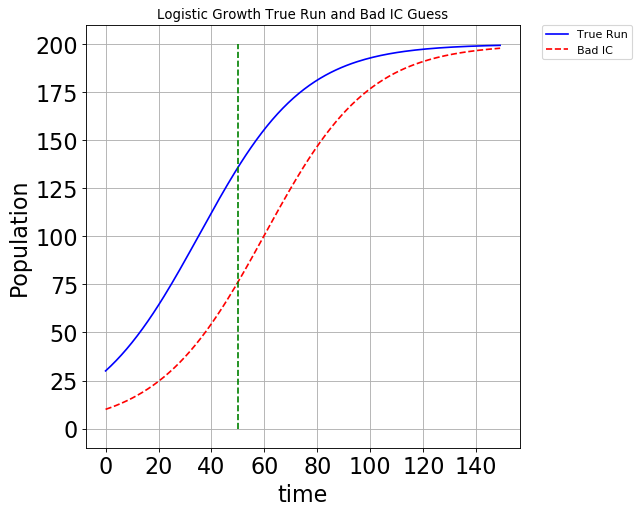

In [18]:
Ptrue = Log_FE(fcstep,dt,Ptrue1,K,r)

PBad = Log_FE(fcstep,dt,Ptrue1+P_err,K,r)

t = np.arange(0,np.size(Ptrue),1);

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(t,Ptrue,'b',label="True Run")
plt.plot(t,PBad,'r--',label="Bad IC")
plt.plot([tend,tend],[0,K],'g--')

plt.xlabel('time',fontsize=20)
plt.ylabel('Population',fontsize=20)
plt.title('Logistic Growth True Run and Bad IC Guess')
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.show()

Figure 1. True System Growth and Perturbed IC growth, left of the green dashed line is the assimilation window. 

### Take Observations of True Growth and Create Weighting Matrix: 

We will now sample at a chosen frequency interval from our true observation run. We will use this sample set as our "observations" of the system.

In [19]:
D = np.zeros(int(tend+1))  
n_obs = int((tend/freq) + 1)
datP = np.zeros(int(tend+1))

for ii in range(0,int(tend+1),int(freq)):
    datP[ii] = Ptrue[ii];
    D[ii] = 1; #D is used as a simple way to bring the model into the observation space. 
    
    



## Plot the Cost Function 
### How should we measure Cost? 

In as simple terms as possible, the cost of the model how "bad" the model performs given an error in the initial conditions. Using our "observations" gathered above, the cost can be determined in the following way, figure 2 shows this formulation. 

\begin{equation}
J = \sum (Perturbed \, Model - Observations)^2
\end{equation}

#### 4dvar:
4dvar is a four dimensional variation method designed to nudge the initial conditions to make a forecast model match observations as closely as possible within an assimilation window. Given that $M$ is our non-linear model which is run on the time interval $(t_0,t_n)$. 4dvar accounts for how far the forward model is from a known background or climatological state, and how different the model is from known observations. The full 4dvar cost function is: 
<img src='4dvar1.png'>

Where $N$ is the number of observations $y_o$, R is the observational error covariance, and H is an operator which translates the model into observation space. Because we have no "background state" and we will assume that our covariance (B) is equal to 1, our model cost function simplifies to: 

\begin{equation}
J(x(t_o)) = \frac{1}{2}  \sum_{i=0}^{N} (H(x_i)-y_i ^0)^T R^{-1} (H(x_i)-y_i ^o)
\end{equation}


Which you can see, since we have a 1D model is very close to our original cost function shown in figure 2. 


The goal of this data assimilation is to minimize the cost function. The minimum will be found by finding the gradient of the cost function (the derivative) and stepping the model in the direction of steepest descent ($-\nabla J$). There are more intelligent ways to step the model (conjugate gradient or quasi-Newton), however, all methods require finding $\nabla J$. In this tutorial we will just use gradient descent: 

\begin{equation}
X_{new} = X_{old} + \rho (-\nabla J)
\end{equation}


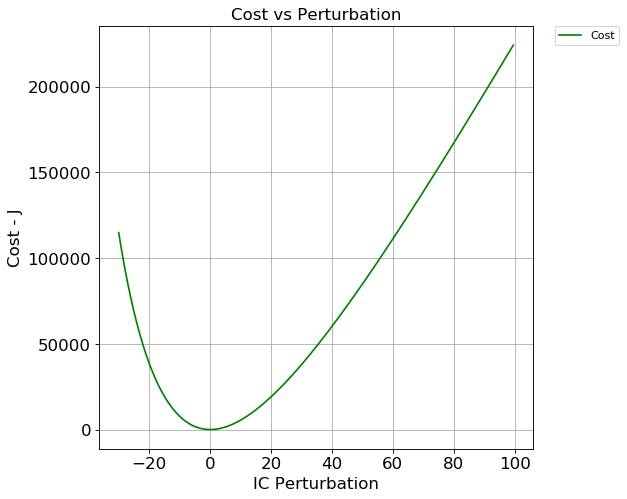

In [22]:
lener = np.arange(0,Ptrue1+100,0.5); #range of perturbed initial conditions 
J =np.zeros(int(np.size(lener))); # initialize array


count = 0 
Multiplier = np.concatenate((D[0:-1], np.zeros(int(fcstep) - np.size(D[0:-1]))), axis=0)
for hh in lener:
    PBad = Log_FE(fcstep,dt,hh,K,r)
    J[count] = (np.sum((PBad-Ptrue)*Multiplier)**2);
    count = count+1;

    
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(lener-Ptrue1,J,'g',label="Cost")
plt.xlabel('IC Perturbation',fontsize=15)
plt.ylabel('Cost - J',fontsize=15)
plt.title('Cost vs Perturbation',fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.grid(True)
plt.show()

Figure 2. Cost function logistic growth. 

This is cost function very friendly, you can see that the adjoint should easily guide us down to the IC because the cost function is convex. However this is not always the case. Take for example the cost functions see below. (Figure taken from: Coveney et al 2016, 'Big Data need Big Theory Too'):   

<img src='costFunction.png'>







## Finding the TLM, The Adjoint Model and the Gradient of the Cost Function

Before we can find the gradient of this cost function we have to discuss tangent linear models and adjoint models. Which will be used as components in the gradient of the cost function 

### Tangent Linear Model

To a first approximation, a perturbation ($\delta x$) of the control variable (initial condition) evolves according to the **tangent linear model** (TLM). A TLM provides a first-order approximation to the evolution of perturbations in a nonlinear forecast trajectory. The TLM thus evolves like $\delta x(t_1) = L\delta x(t_o)$ where L is the linear operator which propagates a perturbation vector forward in time. 

If there are several times steps between $t_o$ and $t_n$ the TLM that advances the perturbation from $t_o$ to $t_n$ is given by the product of the tangent linear model matrices that advance it over each step: 

\begin{equation}
\delta x^n = L_{n-1}\delta x^{n-1}
\end{equation}

therefore,

\begin{equation}
\delta x^{n+1} = L_{n}\delta x^{n} = L_{n}L_{n-1}\delta x^{n-1}= L_{n}L_{n-1}\dots L_o\delta x^{0}
\end{equation}

\begin{equation}
L(t_o,t_n) = \prod_{j=n-1}^{0}L(t_j,t_j+1) = \prod_{j=n-1}^{0}L_j = L_{n-1}L_{n-2}\dots L_{o} 
\end{equation}

Developing a TLM can be done with a simple perturbation method: 

\begin{equation}
L = M(x + \delta x) - M(x)
\end{equation}

Where M is the non-linear model and L is the TLM when all higher order perturbation terms are eliminated. 

For the Logistic growth equation, this is very simple: 

(1)
\begin{equation}
    P_{n+1} = P_n + \Delta t(r*P_n(1-\frac{P_n}{K}))
\end{equation}

(2)
\begin{equation}
P_{n+1} = P_n + \Delta t r P_n - \Delta t \frac{P_n ^2}{K}
\end{equation}

(3)
\begin{equation}
P_{n+1}+\delta P_{n+1} =P_n + \delta P_n + \Delta t r \delta P_n + \Delta t r P_n - \Delta t \frac{r}{K}P_n\delta P_n - \Delta t \frac{r}{K}\delta P_n ^2 - \Delta t \frac{r}{K}P_n ^2
\end{equation}

Subtracting (2) from (3) and eliminating all of the higher order perturbation terms yeilds the TLM: 
\begin{equation}
\delta P_{n+1} = \delta P_n + \Delta t r \delta P_n - \Delta t \frac{r}{K}P_n\delta P_n
\end{equation}

In matrix form (the importance of this form will become clear):


\begin{equation}
\big[\delta P_{n+1} \big] = \big[1 + \Delta t r - \Delta t \frac{r}{K}P_n\big]\big[\delta P_n \big]
\end{equation}


### Adjoint model

An adjoint model is a simplified version of the forward model which runs backwards to propogate sensitivity from the output back to the inputs. IE a forward model propogates temperature, pressure, etc forward in time. A adjoint model predicts the sensitivity to temperature, pressure, etc backwards in time. This will trace an error back to it's roots, the initial conditions, which we can then alter.

The idea is this. For any linear operator ($L$) there exists an adjoint operator ($L^*$) such that: 
\begin{equation}
\big\langle x, L y \big \rangle = \big\langle L^* x, y\big \rangle
\end{equation} 
but $L^*L = I$ 

where $\big\langle , \big \rangle$ is an inner scalar product and x,y are vectors or functions of the space where this product is defined. It can be shown that for the inner product in the [Euclidean Space](https://en.wikipedia.org/wiki/Euclidean_space): 
\begin{equation}
L^* = L^T
\end{equation}

Therefore: 

\begin{equation}
L(t_n,t_o)^T = \prod_{j=0}^{n-1}L(t_{j+1},t_j)^T = \prod_{j=0}^{n-1}L_j^T = L_{o}^TL_{1}^T\dots L_{n-1}^T 
\end{equation}

This shows that an adjoint model brings the perturbations back in time, from the last time step and back to the initial conditions. 

Another way to look at it: 
\begin{equation}
\delta y = \big[ L \big] \delta x
\end{equation}

\begin{equation}
\big[ L \big]^*\delta y  = \big[ L \big] \big[ L \big]^*\delta x
\end{equation}
but $\big[ L^* \big] \big[L\big] = I$
therefore 

\begin{equation}
\big[ L \big]^*\delta y = \delta x
\end{equation}


This is great, so when we are working with equations in the Euclidean space, the adjoint model is just the transpose of the TLM. For the logistic growth equation the adjoint model is as follows: 

\begin{equation}
\big[\delta P_{n+1}^*\big] = \begin{vmatrix} 
1 \\
\Delta t r \\
\Delta t \frac{1}{K}P_n \\
\end{vmatrix}
\big[\delta P_n^*\big]
\end{equation}

Below we have created a function for the Adjoint Model

### Define a function for the Adjoint Model:

In [23]:
def adj_Log(tend,dt,P,datP,r,K,D):
    lP = np.zeros(tend+1)  #initialize my gradient vector.
    
    for jj in range(tend-1,0,-1): #run from the end time step, back to the beginning. 
        PP = 1+dt*r-dt*(r/K)*P[jj]  #adjoint model 
        lP[jj] = 2*dt*D[jj]*(P[jj]-datP[jj])+(lP[jj+1]*PP) #gradient of the Cost Function 
                                                 
    lPo = lP
    return lPo
    
    
    


### Gradient of the Cost Function
Again, let's define the cost function. 

\begin{equation}
J(x(t_o)) = \frac{1}{2}  \sum_{i=0}^{N} (H(x_i)-y_i ^0)^T R^{-1} (H(x_i)-y_i ^o)
\end{equation}

To see how small perturbations propogate through the model we need $\delta J$, a variation in the cost function when the control variable is changed by a small amount. This can be found with a perturbation method. 

\begin{equation}
\delta J = J(x(t_o) + \delta x(t_o) - J(x(t_o)) = \frac{\delta J}{\delta x_1}\delta x_1 + \frac{\delta J}{\delta x_2}\delta x_2 + \dots + \frac{\delta J}{\delta x_n}\delta x_n = \big [ \frac{\partial J}{\partial x(t_o)}\big]^T \delta x(t_o)
\end{equation}

Where the gradient of the cost function $\big [ \frac{\partial J}{\partial x_j(t_o)} \big]$ is a column vector. 

The gradient of the cost function (J) is complicated by the fact that the forward model is a function of different time steps: $x_i = M_i(x(t_o))$. So if we introduce a perturbation to the initial state $( \delta x_i = L(t_o,t_i) \delta x_o) $ so that 

\begin{equation}
\frac{\partial (H(x_i) - y_i ^o) }{\partial x(t_o)} = \frac{\partial H}{\partial x_i}\frac{\partial M}{\partial x_o} =
\frac{\partial H}{\partial x_i}\frac{\partial x_i}{\partial x_o} = H_iL(t_o,t_i) = H_i \prod_{j=i-1}^{0}L(t_j,t_{j+1})
\end{equation}

Where $H_i$ and $L_i$ are the linearized Jacobians, $\frac{\partial H}{\partial x_i}$ and $\frac{\partial M}{\partial x_o}$. THESE LINEARIZED JACOBIANS ARE TANGENT LINEAR MODELS OF OUR NON-LINEAR MODEL!  

After using some matrix differentiation tricks which can be found [HERE](https://atmos.washington.edu/~dennis/MatrixCalculus.pdf) (look at proposition 11). [***TLDR: if $J=y^TAy$ then  $\frac{\partial J}{\partial x} = \big [ \frac{\partial y}{\partial x}  \big ]^T Ay$ given that $y = y(x)$***]: The gradient of our observation cost function is given by:

\begin{equation}
\big [ \frac{\partial J}{\partial x(t_o)} \big ] = \sum_{i=1}^{N}L(t_i,t_o)^T H_i^TR^{-1}(H(x_i)-y_i^o)
\end{equation}

This shows that in order to find the gradient we need to first compute a forward model run, then integrate these increments back to the initial time using the adjoint model. The above statement can be written in a more convenient way. 

Remembering that R = 1, let's say $\bar{d_i} = H_i^T(H(x_i)-y_i^o)$ which is called the weighted observational increment for observations at time $t_i$. Since parts of the backward adjoint integration are common to several time intervals, the summation in the above equation can be written: 

\begin{equation}
\big [ \frac{\partial J}{\partial x(t_o)} \big ] = \sum_{i=1}^{N}L(t_i,t_o)^T \bar{d_i}
\end{equation}

expanding this:

\begin{equation}
\sum_{i=1}^{N}L(t_i,t_o)^T \bar{d_i} = \sum_{i=1}^{N} L_o^T L_1^T \dots L_{i-1}^T \bar{d_i}
\end{equation}

\begin{equation}
=\bar{d_o} + L_o^T \bar{d_1} + \dots + L_o^T L_1^T \dots L_{i-2}^T \bar{d_{i-1}} + L_o^T L_1^T \dots L_{i-1}^T \bar{d_{i}}
\end{equation}

\begin{equation}
=\bar{d_o} + L_o^T (\bar{d_1} + L_1^T(\bar{d_2} + \dots + L_{i-2}^T(\bar{d_{i-1}} + L_{i-1}^T \bar{d_i})))
\end{equation}

This is fairly easy to code. Let's define a function for it below. 

***NOTE** in the below function I am using the non-linear model run rather than the TLM. This is out of laziness and is technically wrong to do, but it's close enough for horseshoes and hand grenades. 

### Define Convergence and Run

We will treat convergence very naively and just allow the model to iterate a given number of times (defined as "conv" in the code) through forward and adjoint runs. A more intelligent design would be to watch the lnorm value (lnorm is determined in the code below) and see when this starts to "level off" or converge on a value.

In [24]:
Pstart = np.zeros(conv)
Pstart[0] = Ptrue1 + P_err; 
lnorm = np.zeros(conv)

kk = 0

#execute while loop until convergence number is met. 

while kk < (conv-1):
    Pnew = Log_FE(fcstep,dt,Pstart[kk],K,r)            #call forward model 
    lp = adj_Log(tend,dt,Pnew,datP,r,K,D)              #call adjoint model 
    lnorm[int(kk)] = lp[1]                             #gradient is the final lp 
    Pstart[kk+1] = Pstart[kk] - 0.05*lnorm[kk]         #gradient descent rho = 0.05 
    kk +=1


## PLOT THE ASSIMILATED RESULTS! 

Figure 3 shows the model slowly climing to the correct initial condition with iterative convergence steps. 
Figure 4 shows the models first and final initial condition runs plotted along side the "true run". 
Figure 5 shows the cost function and the cost of each step the model took.

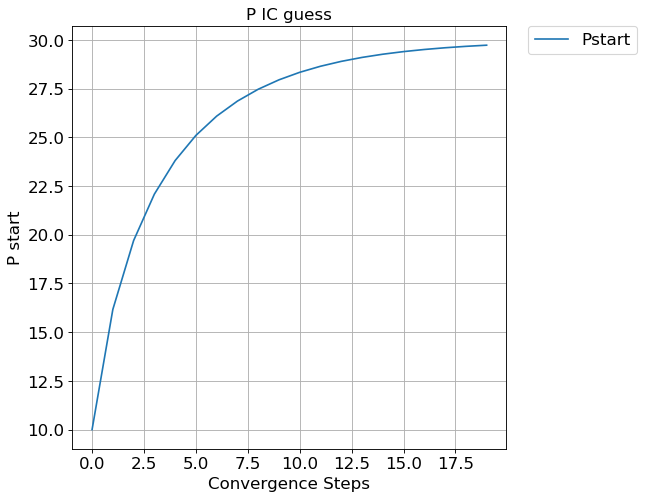

In [30]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Pstart,label='Pstart')
plt.xlabel('Convergence Steps',fontsize=15)
plt.ylabel('P start',fontsize=15)
plt.title('P IC guess',fontsize=15)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
plt.grid(True)
plt.show()



figure 3. IC guess as determined by gradient descent of the cost function



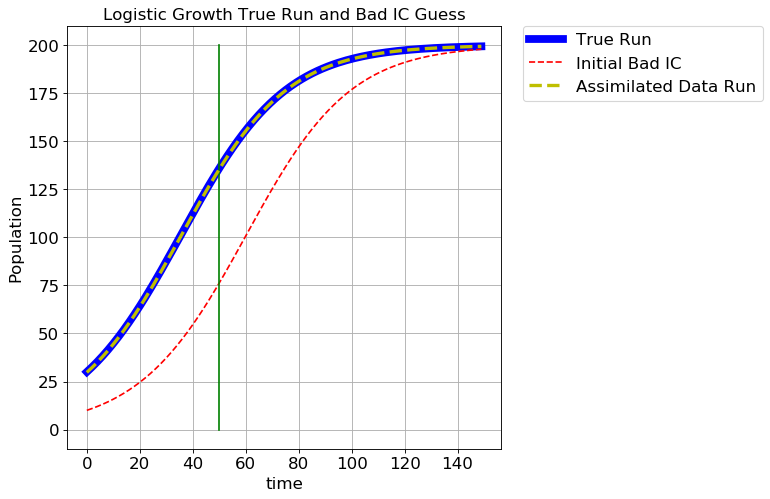

In [34]:
Ptrue = Log_FE(fcstep,dt,Ptrue1,K,r)

PBad = Log_FE(fcstep,dt,Ptrue1+P_err,K,r)

PFinal = Log_FE(fcstep,dt,Pstart[-1],K,r)

t = np.arange(0,np.size(Ptrue),1);
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(t,Ptrue,'b',linewidth=7.0,label="True Run")
plt.plot(t,PBad,'r--',label="Initial Bad IC")
plt.plot([tend,tend],[0,K],'g')
plt.plot(t,PFinal,'y--',linewidth=3.0,label="Assimilated Data Run")

plt.xlabel('time',fontsize=15)
plt.ylabel('Population',fontsize=15)
plt.title('Logistic Growth True Run and Bad IC Guess',fontsize=15)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)

plt.grid(True)
plt.show()

figure 4. Figure with assimilated data, left of green is the assimilation window.  

### Plot the Steps taken on the cost function


[3.86826536e+04 1.60509327e+04 8.26408476e+03 4.65193272e+03
 2.75367538e+03 1.68340988e+03 1.05221597e+03 6.68289265e+02
 4.29522123e+02 2.78566378e+02 1.81928746e+02 1.19465644e+02
 7.87870857e+01 5.21380218e+01 3.45974445e+01 2.30085806e+01
 1.53287608e+01 1.02270024e+01 6.83118073e+00 4.56724610e+00]


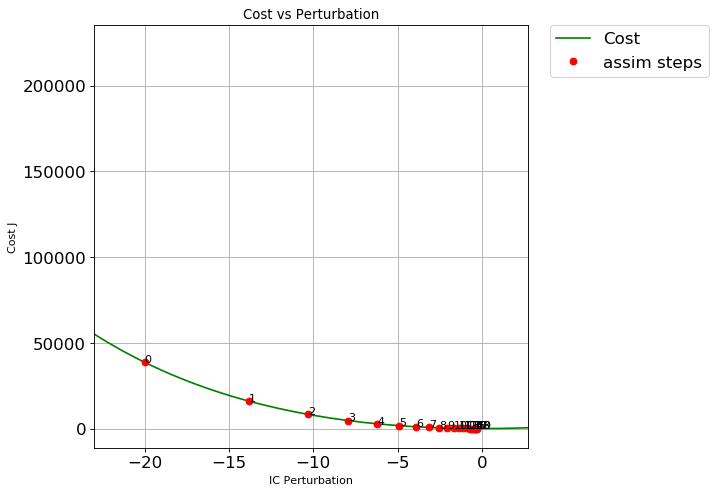

In [40]:
#plot the steps we took down the cost function. 

JPstart =np.zeros(int(np.size(Pstart))); # initialize array
count = 0 
Multiplier = np.concatenate((D[0:-1], np.zeros(int(fcstep) - np.size(D[0:-1]))), axis=0)
for hh in Pstart:
    PBad = Log_FE(fcstep,dt,hh,K,r)
    JPstart[count] = (np.sum((PBad-Ptrue)*Multiplier))**2;
    count = count+1;

print(JPstart)
 
    
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(lener-Ptrue1,J,'g',label="Cost")
plt.plot(Pstart-Ptrue1,JPstart,'ro',label="assim steps")
for jr in range(JPstart.shape[0]):
    plt.text(Pstart[jr]-Ptrue1,JPstart[jr], str(jr))
plt.xlabel('IC Perturbation')
plt.ylabel('Cost J')
plt.title('Cost vs Perturbation')
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15)
plt.grid(True)

pylab.xlim([min(Pstart-Ptrue1)-3,max(Pstart-Ptrue1)+3])
plt.show()


Figure 5. IC starts on the cost function, red dotted numbers indicate step number

# Now Let's Look at a slightly more complicated Model

***note:*** you will see a lot of repeated material between this tutorial for the more complicated model and the above logistic growth model. I thought it would be beneficial to see most of it again.

### Background information on Lorenz63
Background information on Lorenz: [Lorenz63](https://en.wikipedia.org/wiki/Lorenz_system) 

Again we will start with a function that runs a forward model using Forward Euler. 


The forward Euler scheme for the Lorenz equations is as follows: 

(1)
\begin{equation}
x_{n+1} = x_n + \Delta t(\sigma(y_n -x_n))
\end{equation}
(2)
\begin{equation}
y_{n+1} = y_n + \Delta t(x_n\rho -z_n x_n - y_n)
\end{equation}
(3)
\begin{equation}
z_{n+1} = z_n + \Delta t(y_n x_n - \beta z_n)
\end{equation}

Below we will set the parameter values and define a function for Forward Euler.

### Forward Model Run and Variable Set Screws:

We will be using an initial forward model run to simulate what we would like our data assimilated model to eventually mimic. It will be used to take observations from and for the final model validation. The observations will be the data that is assimilated into the model to correct the flawed initial condition gues

In [42]:
dt = 0.001   #tiny little time step... this has to be small because Forward Euler is Garbage for Lorenze 
conv = 50    #how many steps we give the model to converge. 
xerr = 0.2   #applied error in x 
yerr = 0.1   #applied error in y
zerr = -0.1  #applied error in z 

#################
#Lorenz Parameters 
a = 10      #sigma 
B = 8/3     #beta 
r = 28      #rho 
#################

freq  = 8 #frequency of observations 
ta = 8    #observation window
tf = 2    #forecast window 
tstep = ta/dt #time step 
tstep = int(round(tstep))
fcstep = (ta+tf)/dt
fcstep = int(round(fcstep))

###############
#true values we start with and eventually want to assimilate towards
###############
xs = 1
ys = 1
zs = 2
############################################

#Forward Euler Function, Lorenz


def LOeuler(tstep,dt,xs,ys,zs,a,r,B):
    xval = np.zeros((tstep,1))
    yval = np.zeros((tstep,1))
    zval = np.zeros((tstep,1))
    xval[0,0]=xs 
    yval[0,0]=ys
    zval[0,0]=zs
    
    for ii in range(0,tstep-2):
        xval[ii+1,0] = xval[ii,0]+dt*(a*(yval[ii,0]-xval[ii,0]))
        yval[ii+1,0] = yval[ii,0]+dt*(r*xval[ii,0]-xval[ii,0]*zval[ii,0]-yval[ii,0])
        zval[ii+1,0] = zval[ii,0]+dt*(xval[ii,0]*yval[ii,0]-B*zval[ii,0])
    return xval,yval,zval,





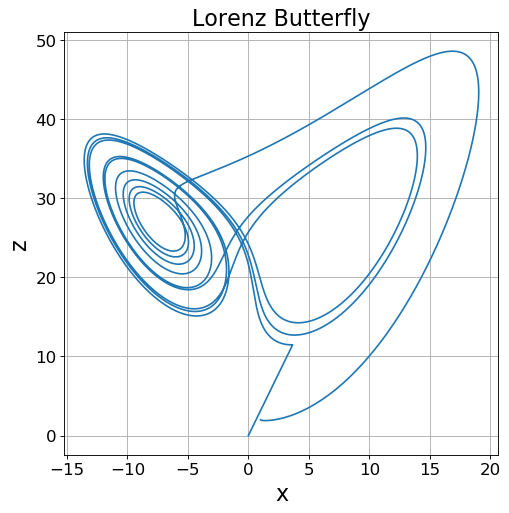

In [44]:
Tx,Ty,Tz = LOeuler(fcstep,dt,xs,ys,zs,a,r,B)

Tx = np.append(Tx,[Tx[-1]]);
Ty = np.append(Ty,[Ty[-1]]);
Tz = np.append(Tz,[Tz[-1]]);

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(Tx,Tz)
plt.xlabel('x',fontsize=20)
plt.ylabel('z',fontsize=20)
plt.title('Lorenz Butterfly',fontsize=20)
plt.grid(True)

plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.show()

Figure 6. The begining wing of the lorenze butterfly. 


## The Cost Function 
### How should we measure Cost? 

What do we mean by cost? In as simple terms as possible, the cost of the model how "bad" the model performs given an error in the initial conditions. Using our "observations" gathered above, the cost can be determined in the following way, figure 2 shows this formulation. 

\begin{equation}
J(x,y,z) = \sum (Perturbed \, Model - Observations)^2
\end{equation}

#### 4dvar:
4dvar is a four dimensional variation method design to nudge the initial conditions to make a forecast model match observations as closely as possible within an assimilation window. Given that $M$ is our non-linear model which is run on the time interval $(t_0,t_n)$. 4dvar accounts for how far the forward model is from a known background or climatological state, and how different the model is from known observations. The full 4dvar cost function is: 
<img src='4dvar1.png'>

Where $N$ is the number of observations $y_o$, R is the observational error covariance, and H is an operator which translates the model into observation space. Because we have no "background state" and we will assume that our covariance (R) is equal to 1, our model cost function simplifies to: 

\begin{equation}
J(x(t_o)) = \frac{1}{2}  \sum_{i=0}^{N} (H(x_i)-y_i ^0)^T R^{-1} (H(x_i)-y_i ^o)
\end{equation}


The goal of this data assimilation is to minimize the cost function. The minimum will by found by finding the gradient of the cost function (the derivative) and stepping the model in the direction of steepest descent ($-\nabla J$). There are more intelligent ways to step the model (conjugate gradient or quasi-Newton), however, all methods require finding $\nabla J$. In this tutorial we will just use gradient descent: 

\begin{equation}
X_{new} = X_{old} + \rho (-\nabla J)
\end{equation}



## Finding the TLM, The Adjoint Model and the Gradient of the Cost Function

Before we can find the gradient of this cost function we have to discuss tangent linear models and adjoint models. Which will be used as components in the gradient of the cost function 

### Tangent Linear and Adjoint Models

#### Tangent Linear Model

To a first approximation, a perturbation ($\delta x$) of the control variable (initial condition) evolves according to the **tangent linear model** (TLM). A TLM provides a first-order approximation to the evolution of perturbations in a nonlinear forecast trajectory. The TLM thus evolves like $\delta x(t_1) = L\delta x(t_o)$ where L is the linear operator which propagates a perturbation vector forward in time. 

If there are several times steps between $t_o$ and $t_n$ the TLM that advances the perturbation from $t_o$ to $t_n$ is given by the product of the tangent linear model matrices that advance it over each step: 

\begin{equation}
\delta x^n = L_{n-1}\delta x^{n-1}
\end{equation}

therefore,

\begin{equation}
\delta x^{n+1} = L_{n}\delta x^{n} = L_{n}L_{n-1}\delta x^{n-1}= L_{n}L_{n-1}\dots L_o\delta x^{o}
\end{equation}

\begin{equation}
L(t_o,t_n) = \prod_{j=n-1}^{0}L(t_j,t_j+1) = \prod_{j=n-1}^{0}L_j = L_{n-1}L_{n-2}\dots L_{o} 
\end{equation}

Developing a TLM can be done with a simple perturbation method: 

\begin{equation}
L = M(x + \delta x) - M(x)
\end{equation}

Where M is the non-linear model and L is the TLM when all higher order perturbation terms are eliminated. 
For the Lorenz Equations, this is simple, the perturbation equations are as follows: 

(4)
\begin{equation}
x_{n+1} + \delta x_{n+1} = (x_n + \delta x_n) - \sigma (x_n + \delta x_n) + \sigma (y_n + \delta y_n)
\end{equation}

(5)
\begin{equation}
y_{n+1} + \delta y_{n+1} = y_n + \delta y_n + \Delta t x_n\rho + \Delta t \delta x_n\rho - x_n z_n \Delta t - \delta x_n z_n \Delta t  - x_n \delta z_n \Delta t - \delta x_n \delta z_n \Delta t - y \Delta t - \delta y \Delta t
\end{equation}

(6)
\begin{equation}
z_{n+1} + \delta z_{n+1} = z_n + \delta z_n - x_n y_n \Delta t + \delta x_n y_n \Delta t + x_n \delta y_n \Delta t - \beta z_n \Delta t - \beta \delta z_n \Delta t
\end{equation}




Subtracting: (1)-(4), (2)-(5),(3)-(6) and eliminating all of the higher order perturbation terms yeilds the TLM. In matrix form:

\begin{equation}
 \left(\begin{array}{c} 
\delta x_{n+1}\\
\delta y_{n+1} \\
\delta z_{n+1} \\
\end{array}\right) = 
\left(\begin{array}{ccc} 
1-\sigma \Delta t & \sigma \Delta t & 0 \\
(\rho - z_n)\Delta t & 1-\Delta t & -x_n \Delta t \\
y_n \Delta t & x_n \Delta t & 1 - \beta \Delta t \\
\end{array}\right)
\left(\begin{array}{c} 
\delta x_{n}\\
\delta y_{n}\\
\delta z_{n}\\
\end{array}\right)
\end{equation}


#### Adjoint model

An adjoint model is a simplified version of the forward model which runs backwards to propogate sensitivity from the output back to the inputs. IE a forward model propogates temperature, pressure, etc forward in time. A adjoint model predicts the sensitivity to temperature, pressure, etc backwards in time. This will trace an error back to it's roots, the initial conditions, which we can then alter.

The idea is this. For any linear operator ($L$) there exists an adjoint operator ($L^*$) such that: 
\begin{equation}
\big\langle x, L y \big \rangle = \big\langle L^* x, y\big \rangle
\end{equation} 
but $L^*L = I$ 

where $\big\langle , \big \rangle$ is an inner scalar product and x,y are vectors or functions of the space where this product is defined. It can be shown that for the inner product in the [Euclidean Space](https://en.wikipedia.org/wiki/Euclidean_space): 
\begin{equation}
L^* = L^T
\end{equation}

Therefore: 

\begin{equation}
L(t_n,t_o)^T = \prod_{j=n-1}^{0}L(t_j,t_j+1)^T = \prod_{j=n-1}^{0}L_j^T = L_{n-1}^TL_{n-2}^T\dots L_{o}^T 
\end{equation}

This shows that an adjoint model brings the perturbations back in time, from the last time step and back to the initial conditions. 

Another way to look at it: 
\begin{equation}
\delta y = \big[ L \big] \delta x
\end{equation}

\begin{equation}
\big[ L \big]^*\delta y  = \big[ L \big] \big[ L \big]^*\delta x
\end{equation}
but $\big[ L^* \big] \big[L\big] = I$
therefore 

\begin{equation}
\big[ L \big]^*\delta y = \delta x
\end{equation}


This is great, so when we are working with equations in the Euclidean space, the adjoint model is just the transpose of the TLM. For the Lorenz equations the adjoint model is:  




\begin{equation}
 \left(\begin{array}{c} 
\delta x_{n+1}^*\\
\delta y_{n+1}^* \\
\delta z_{n+1}^* \\
\end{array}\right) = 
\left(\begin{array}{ccc} 
1-\sigma \Delta t & (\rho - z_n)\Delta t & y_n \Delta t \\
\sigma \Delta t & 1-\Delta t & x_n \Delta t \\
0 & -x_n \Delta t & 1 - \beta \Delta t \\
\end{array}\right)
\left(\begin{array}{c} 
\delta x_{n}^*\\
\delta y_{n}^*\\
\delta z_{n}^*\\
\end{array}\right)
\end{equation}

### Function for the adjoint model

In [45]:
def adjFE(tstep,dt,x,y,z,datx,daty,datz,a,r,B,D):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #%
    #%  Purpose: Calculate gradient of cost function by means of
    #%           adjoint of Forward Euler scheme
    #%
    #%  List of main variables
    #%    a:          sigma coefficient in equations
    #%    r:          rho coefficient in equations
    #%    b:          beta coefficient in equations
    #%    D:          Observation weighting matrix
    #%    h:          Time step for numerical scheme
    #%    tstep:      Number of time steps to perform
    #%    [x,y,z]:    Forward trajectory
    #%    [datx,daty,datz]: Observation values
    #%
    #%  Output:
    #%    [lxo,lyo,lzo]: Trajectories of gradient fields
    #%   
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    lx = np.zeros((tstep+1,1))
    ly = np.zeros((tstep+1,1))
    lz = np.zeros((tstep+1,1))
    l = np.zeros((3,tstep+1))

    
    for jj in range(tstep-1,0,-1):
        #gradients wrt each variable 
        xx = 1 - a*dt
        xy = (r-z[jj])*dt
        xz = y[jj]*dt
        
        yx = a*dt
        yy = 1-dt
        yz = x[jj]*dt
        
        zx = 0
        zy = -dt*x[jj]
        zz = 1-dt*B

        #update gradient of cost function 
        
        ADmat = np.matrix([[xx, xy, xz], [yx, yy, yz], [zx, zy, zz]])        
        obsTLMvec = np.array([(x[jj]-datx[jj]),(y[jj]-daty[jj]),(z[jj]-datz[jj])]);
        
        g =  ADmat*(2*dt*D[jj]*obsTLMvec) + ADmat*l[:,jj+1].reshape(3,1)
        l[:,jj] =g.reshape(3,);
                
        #lx[jj] = 2*dt*D[jj]*(x[jj]-datx[jj])+lx[jj+1]*xx+ly[jj+1]*xy+lz[jj+1]*xz
        #ly[jj] = 2*dt*D[jj]*(y[jj]-daty[jj])+lx[jj+1]*yx+ly[jj+1]*yy+lz[jj+1]*yz
        #lz[jj] = 2*dt*D[jj]*(z[jj]-datz[jj])+lx[jj+1]*zx+ly[jj+1]*zy+lz[jj+1]*zz
        
        lx[jj] = l[0,jj]
        ly[jj] = l[1,jj]
        lz[jj] = l[2,jj]
         
    return lx,ly,lz,l,ADmat

 

### Gradient of the Cost Function
Again, let's define the cost function. 

\begin{equation}
J(x(t_o)) = \frac{1}{2}  \sum_{i=0}^{N} (H(x_i)-y_i ^0)^T R^{-1} (H(x_i)-y_i ^o)
\end{equation}

To see how small perturbations propogate through the model we need $\delta J$, a variation in the cost function when the control variable is changed by a small amount. This can be found with a perturbation method. 

\begin{equation}
\delta J = J(x(t_o) + \delta x(t_o) - J(x(t_o)) = \frac{\delta J}{\delta x_1}\delta x_1 + \frac{\delta J}{\delta x_2}\delta x_2 + \dots + \frac{\delta J}{\delta x_n}\delta x_n = \big [ \frac{\partial J}{\partial x(t_o)}\big]^T \delta x(t_o)
\end{equation}

Where the gradient of the cost function $\big [ \frac{\partial J}{\partial x_j(t_o)} \big]$ is a column vector. 

The gradient of the cost function (J) is complicated by the fact that the forward model is a function of different time steps: $x_i = M_i(x(t_o))$. So if we introduce a perturbation to the initial state $( \delta x_i = L(t_o,t_i) \delta x_o) $ so that 

\begin{equation}
\frac{\partial (H(x_i) - y_i ^o) }{\partial x(t_o)} = \frac{\partial H}{\partial x_i}\frac{\partial M}{\partial x_o} =
\frac{\partial H}{\partial x_i}\frac{\partial x_i}{\partial x_o} = H_iL(t_o,t_i) = H_i \prod_{j=i-1}^{0}L(t_j,t_{j+1})
\end{equation}

Where $H_i$ and $L_i$ are the linearized Jacobians, $\frac{\partial H}{\partial x_i}$ and $\frac{\partial M}{\partial x_o}$. THESE LINEARIZED JACOBIANS ARE TANGENT LINEAR MODELS OF OUR NON-LINEAR MODEL!  

After using some matrix differentiation tricks which can be found [HERE](https://atmos.washington.edu/~dennis/MatrixCalculus.pdf) (look at proposition 11). [***TLDR:  $\frac{\partial J}{\partial x} = \big [ \frac{\partial y}{\partial x}  \big ]^T Ay$ given that $y = y(x)$***]: The gradient of our observation cost function is given by:

\begin{equation}
\big [ \frac{\partial J}{\partial x(t_o)} \big ] = \sum_{i=1}^{N}L(t_i,t_o)^T H_i^TR^{-1}(H(x_i)-y_i^o)
\end{equation}

This shows that in order to find the gradient we need to first compute a forward model run, then integrate these increments back to the initial time using the adjoint model. The above statement can be written in a more convenient way. 

Remembering that R = 1, let's say $\bar{d_i} = H_i^T(H(x_i)-y_i^o)$ which is called the weighted observational increment for observations at time $t_i$. Since parts of the backward adjoint integration are common to several time intervals, the summation in the above equation can be written: 

\begin{equation}
\big [ \frac{\partial J}{\partial x(t_o)} \big ] = \sum_{i=1}^{N}L(t_i,t_o)^T \bar{d_i}
\end{equation}

expanding this:

\begin{equation}
\sum_{i=1}^{N}L(t_i,t_o)^T \bar{d_i} = \sum_{i=1}^{N} L_o^T L_1^T \dots L_{i-1}^T \bar{d_i}
\end{equation}

\begin{equation}
=\bar{d_o} + L_o^T \bar{d_1} + \dots + L_o^T L_1^T \dots L_{i-2}^T \bar{d_{i-1}} + L_o^T L_1^T \dots L_{i-1}^T \bar{d_{i}}
\end{equation}

\begin{equation}
=\bar{d_o} + L_o^T (\bar{d_1} + L_1^T(\bar{d_2} + \dots + L_{i-2}^T(\bar{d_{i-1}} + L_{i-1}^T \bar{d_i})))
\end{equation}

This is fairly easy to code. Let's define a function for it below. 

***NOTE** in the below function I am using the non-linear model run rather than the TLM. This is out of laziness and is technically wrong to do, but it's close enough for horseshoes and hand grenades. 

### We now take our observations and create the H matrix which brings our model into observation space. 

In [46]:
#Set up Data and Observations of data
D = np.zeros((tstep+1,1))     #H matrix which brings model space ====> observation space 
datx = np.zeros((tstep+1,1))  #data in x
daty = np.zeros((tstep+1,1))  #data in y
datz = np.zeros((tstep+1,1))  #data in z

n_obs =int(round((tstep/freq)+1))   #number of observations

for ii in range(0,int(tstep+1),int(freq)):   #go over true run at a specified frequency
    datx[ii] = Tx[ii];
    daty[ii] = Ty[ii];
    datz[ii] = Tz[ii];
    D[ii] = 1; 

### Define Convergence and Run

We will treat convergence very naively and just allow the model to iterate a given number of times (defined as "conv" in the code) through forward and adjoint runs. A more intelligent design would be to watch the lnorm value (lnorm is determined in the code below) and see when this starts to "level off" or converge on a value.

In [47]:
#initialize my vectors: 
xstart = np.zeros((conv,1))
ystart = np.zeros((conv,1))
zstart = np.zeros((conv,1))
lnorm = np.zeros((conv,1))

#set noisy initial conditions ===>
xstart[0] = xs + xerr
ystart[0] = ys + yerr
zstart[0] = zs + zerr

kk = 0
while kk < (conv-1):
    x,y,z = LOeuler(fcstep,dt,xstart[kk],ystart[kk],zstart[kk],a,r,B);  #call the forward model 
    x = np.append(x,[x[-1]]); #sloppily ammend values to match the forward run. 
    y = np.append(y,[y[-1]]);
    z = np.append(z,[z[-1]]);
    
    lx,ly,lz,l,ADmat = adjFE(tstep,dt,x,y,z,datx,daty,datz,a,r,B,D);   #call the adjoint model 
    lnorm[kk]=math.sqrt(lx[1]*lx[1]+ly[1]*ly[1]+lz[1]*lz[1]);          #normalize the gradient 
    gx=lx[1]/lnorm[kk];                                                #find gradient in xyz. 
    gy=ly[1]/lnorm[kk];
    gz=lz[1]/lnorm[kk];
    
    xstart[kk+1]=xstart[kk]-0.03*gx;                                   #apply the steps in the gradient direction 
    ystart[kk+1]=ystart[kk]-0.03*gy;
    zstart[kk+1]=zstart[kk]-0.03*gz;
    kk = kk +1;





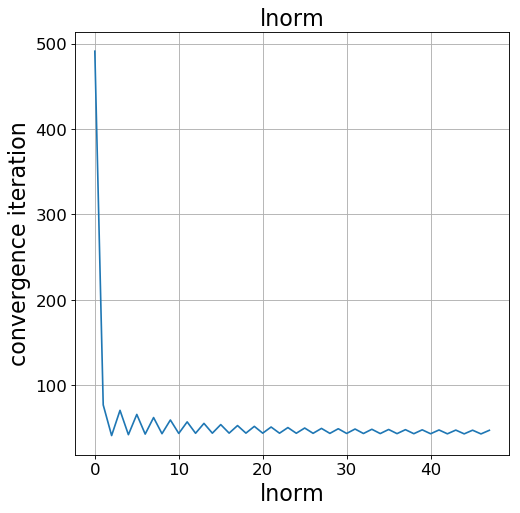

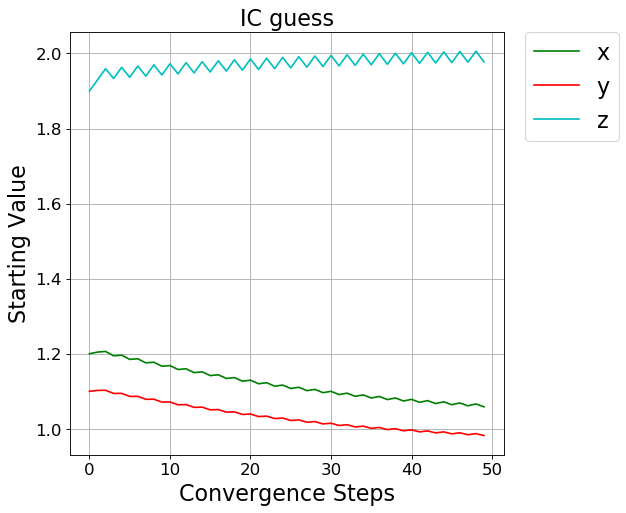

In [53]:
plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(lnorm[0:-2])
plt.xlabel('lnorm',fontsize=20)
plt.ylabel('convergence iteration',fontsize=20)
plt.title('lnorm',fontsize=20)
plt.grid(True)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.show()


plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(xstart,'g',label='x')
plt.plot(ystart,'r',label='y')
plt.plot(zstart,'c',label='z')
plt.xlabel('Convergence Steps',fontsize=20)
plt.ylabel('Starting Value',fontsize=20)
plt.title('IC guess',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.grid(True)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.show()

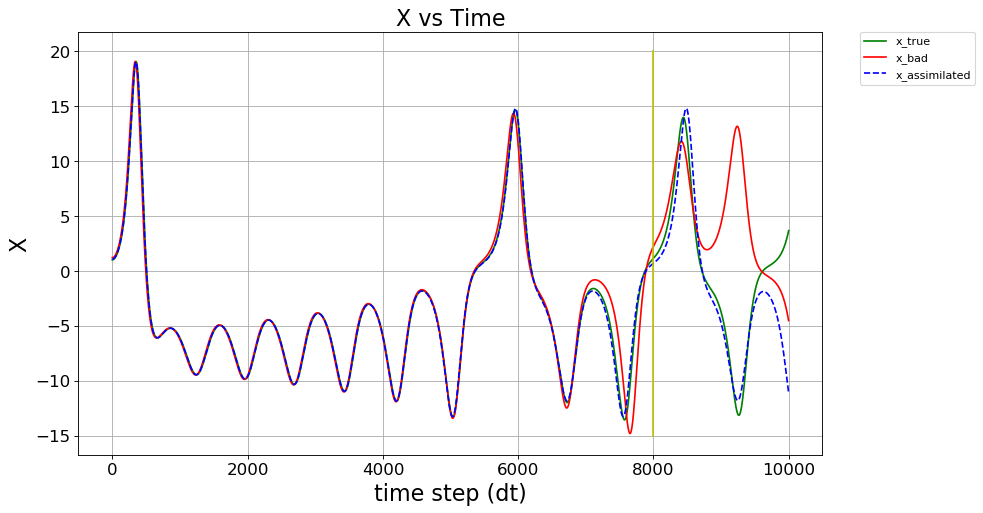

In [59]:
Tbadx,Tbady,Tbadz = LOeuler(fcstep,dt,xs+xerr,ys+yerr,zs+zerr,a,r,B)  #run bad first model run 

Tendx,Tendy,Tendz = LOeuler(fcstep,dt,xstart[-2],ystart[-2],zstart[-2],a,r,B) #run good last model run 


#plot it all 
plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Tx[0:-2],'g',label='x_true')
plt.plot(Tbadx[0:-2],'r',label='x_bad')
plt.plot(Tendx[0:-2],'b--',label='x_assimilated')
plt.plot([tstep,tstep],[-15,20],'y')

plt.xlabel('time step (dt)',fontsize=20)
plt.ylabel('X',fontsize=20)
plt.title('X vs Time',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
plt.show()

figure 8. Xtrue, X first initial conditions, Xfinal initial conditions, with time forecast window is to the right of the solid yellow line. 


Above is the plot of the final system using the assimilated data comparing this with the original 'Bad' guess and the final assimilated guess. It is clear that the assimilated data performs much better in the forecast window. YEWWWW! 

## Citations: 

 -- Kalnay, E., 2003: Atmospheric Modeling, Data Assimilation and Predictability; Cambridge University Press. 369pp.

 -- ECMWF DA school precedings 

 -- Lorenze 4d-Var data assimilation matlab code Amos Lawless and Marek Wlasak, 2002 Data Assimilation Research Centre

**Big thanks to:** 

Aneesh Subramanian & Bruce Cornuelle & Ian Eisenman